In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

In [2]:
# Static variables containing data about ECMAScript releases
es_releases = [
    (3, 'Dec 1999'), 
    (5, 'Dec 2009'), 
    (6, 'Jun 2015'), 
    (7, 'Jun 2016'), 
    (8, 'Jun 2017'), 
    (9, 'Jun 2018'), 
    (10, 'Jun 2019'), 
    (11, 'Jun 2020'), 
    (12, 'Jun 2021'), 
    (13, 'Jun 2022'), 
    (14, 'Jun 2023'), 
    (15, 'Jun 2024')
]

# List of ECMAScript versions
es_versions = [ver for (ver, date) in es_releases]

# List of ECMAScript release dates
es_release_dates = [datetime.strptime(date, '%b %Y') for (ver, date) in es_releases]

# Converting Signatures
Function for converting the modernity signature generation output into usable X, Y and Z axis data for matplotlib

In [4]:
zip2d = lambda a, b: [list(zip(row1, row2)) for row1, row2 in zip(a, b)]

def gen_x_y_z(dataset):
    release_dates = [key for key, value in dataset.signatures.items() if type(value) is dict]

    es_version_indices = range(len(es_versions))
    
    X, Y = np.meshgrid(es_version_indices, release_dates)

    Z_agg_list = []
    Z_bool_list = []

    for row in zip2d(X,Y):
        new_row_agg = []
        new_row_bool = []
        
        for es_version_index, release_date in row:
            es_version = str(es_versions[es_version_index])

            value_agg = dataset.signatures[release_date]['aggregate'][es_version]
            value_bool = dataset.signatures[release_date]['boolean'][es_version]
            
            new_row_agg.append(value_agg)
            new_row_bool.append(value_bool)

        Z_agg_list.append(new_row_agg)
        Z_bool_list.append(new_row_bool)

    Z_agg = np.array(Z_agg_list)
    Z_bool = np.array(Z_bool_list)

    return X, Y, Z_agg, Z_bool

# Normalization Functions
Normalization functions for modernity signatures

In [6]:
def normalize_max(values, maxValues):
    normalized = []

    for row in values:
        normalized_row = []
        
        for value in row:
            normalized_value = value / max(row)
            normalized_row.append(normalized_value)

        normalized.append(normalized_row)

    return normalized

def normalize_maxmin(values, maxValues):
    normalized = []

    for row in values:
        normalized_row = []
        
        for value in row:
            normalized_value = (value - min(row)) / (max(row) - min(row))
            normalized_row.append(normalized_value)

        normalized.append(normalized_row)

    return normalized

def normalize_vector(values, maxValues):
    normalized = []

    for row in values:
        normalized_row = []
        
        for value in row:
            row_float64 = np.array(row, dtype=np.float64) # Prevent overflow for large numbers
            normalized_value = value / np.sqrt(np.sum(np.power(row_float64, 2)))
            normalized_row.append(normalized_value)

        normalized.append(normalized_row)

    return normalized

def normalize_zscore(values, maxValues):
    normalized = []

    for row in values:
        normalized_row = []
        
        for value in row:
            normalized_value = (value - np.mean(row)) / np.std(row)
            normalized_row.append(normalized_value)

        normalized.append(normalized_row)

    return normalized

def normalize_log(values, maxValues):
    normalized = []

    for row in values:
        normalized_row = []
        
        for value in row:
            if value == 0:
                normalized_row.append(0)
            else:
                row_filtered = list(filter(lambda x: x != 0, row))
    
                # Using math rule: log(A*B) = log(A) + log(B)
                normalized_value = np.log(value) / np.sum(np.log(row_filtered))
                normalized_row.append(normalized_value)

        normalized.append(normalized_row)

    return normalized

def normalize_max_detectable(values, maxValues):
    normalized = []

    for row in values:
        normalized_row = []

        index = 0
        for value in row:
            maxValue = maxValues[index]

            if maxValue == 0:
                normalized_row.append(0)
            else:
                normalized_value = value / maxValues[index]
                normalized_row.append(normalized_value)
                
            index = index + 1

        normalized.append(normalized_row)

    return normalized

# Plot Generation
Code for generating plots

In [8]:
def get_relevant_es_releases(release_dates):
    first_release_date = min([min(row) for row in mdates.date2num(release_dates)])

    relevant_es_release_dates = []
    relevant_es_version_indices = []
    
    for index, date in enumerate(mdates.date2num(es_release_dates)):
        if date >= first_release_date:
            relevant_es_release_dates.append(date)
            relevant_es_version_indices.append(index)

    return relevant_es_release_dates, relevant_es_version_indices

def gen_plot(title, dataset, normalizer, agg_or_bool):    
    X, Y, Z_agg, Z_bool = gen_x_y_z(dataset)

    # Get maximum amount of detectable features for every ES version from metadata
    maxValues = [value for key, value in dataset.meta.signBoolMaxDetectable.items()]
    
    # Run normalization function on signatures
    if agg_or_bool == 'aggregate':
        Z_normalized = np.array(normalizer(Z_agg, maxValues))
    elif agg_or_bool == 'boolean':
        Z_normalized = np.array(normalizer(Z_bool, maxValues))
    else:
        raise Exception(f'Expected agg_or_bool to be either \'aggregate\' or \'boolean\' but got \'{agg_or_bool}\'')
        return None
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    # Visual settings
    ax.set_box_aspect((8, 8, 4))
    ax.set_title(title)
    ax.set_xlabel("ES Version")
    ax.set_ylabel("Release Date")
    ax.set_zlabel("Amount of Detected Features")
    
    # Plot signatures
    ax.plot_surface(
        X, 
        mdates.date2num(Y), 
        Z_normalized, 
        cmap=plt.get_cmap('Blues')
    )

    y_min, y_max = ax.get_ylim()
    z_min, z_max = ax.get_zlim()

    # Use custom labels for ECMAScript version axis
    ax.set_xticks(list(range(len(es_versions))), labels=list(es_versions))

    # Format release dates to YYYY
    ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Plot a red border showing the release dates for ES versions
    border_X = list(range(len(es_versions)))
    border_Y = np.clip(mdates.date2num(es_release_dates), y_min, y_max)
    border_Z = z_min * np.ones(len(border_Y))
    ax.plot(
        border_X, 
        border_Y, 
        border_Z,
        color='red',
        linewidth=1,
        zorder=2
    )
    
    ax.set_ylim([y_min, y_max])

    return plt

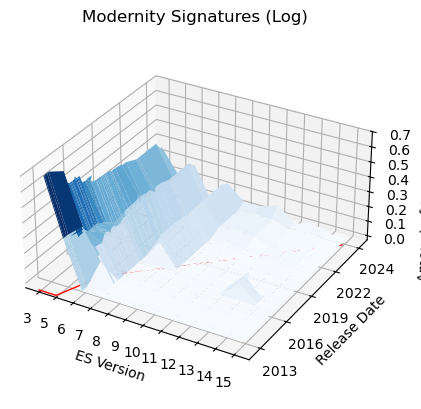

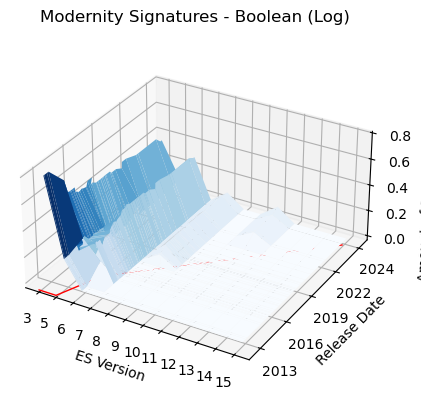

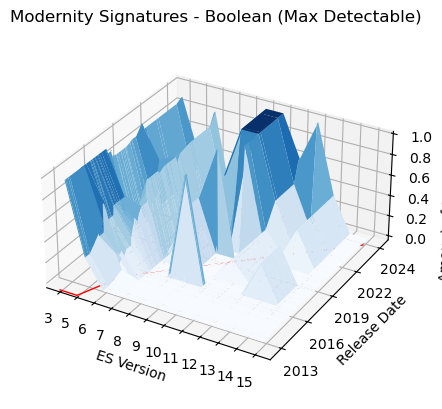

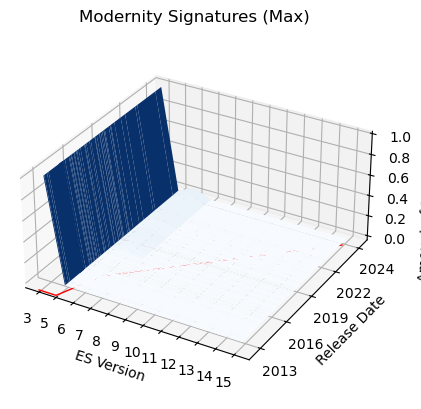

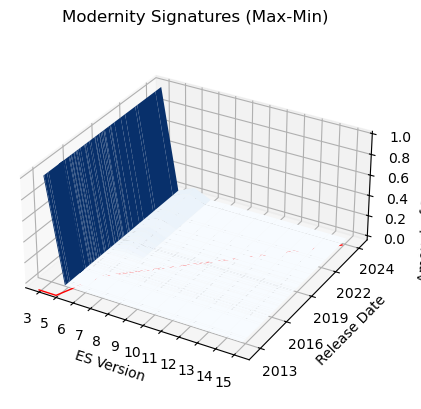

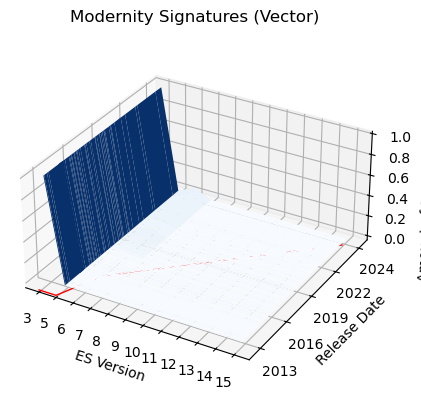

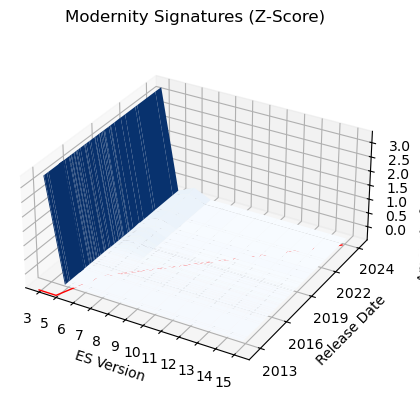

In [9]:
title = "Modernity Signatures"

# --- Feature usage before actually added (use of transpilers like babel)
# > ES9 (2018) object rest operator in 2016
# > ES13 (2022) static class fields in 2016
dataset = pd.read_json('result_signatures/signatures_facebook_react_2025-01-06T22-30-50-661Z.json')

# --- Difference between just counting and boolean counting 
# 
# > different types of features are slowly getting used more
# dataset = pd.read_json('result_signatures/signatures_atlassian_react-beautiful-dnd_2025-01-07T14-52-51-607Z.json')
#
# > feature that wasn't visible on the non-boolean graph
# dataset = pd.read_json('result_signatures/signatures_GitSquared_edex-ui_2025-01-07T14-29-18-651Z.json')

# --- Relatively boring graph but looks nice
# 
# dataset = pd.read_json('result_signatures/signatures_mozilla_pdf-js_2025-01-07T13-20-54-115Z.json')

# Generate plot from data
plt = gen_plot(title + " (Log)", dataset, normalize_log, 'aggregate')
plt.show()

plt = gen_plot(title + " - Boolean (Log)", dataset, normalize_log, 'boolean')
plt.show()

plt = gen_plot(title + " - Boolean (Max Detectable)", dataset, normalize_max_detectable, 'boolean')
plt.show()

plt = gen_plot(title + " (Max)", dataset, normalize_max, 'aggregate')
plt.show()

plt = gen_plot(title + " (Max-Min)", dataset, normalize_maxmin, 'aggregate')
plt.show()

plt = gen_plot(title + " (Vector)", dataset, normalize_vector, 'aggregate')
plt.show()

plt = gen_plot(title + " (Z-Score)", dataset, normalize_zscore, 'aggregate')
plt.show()
